### Priority
* First, analyze and get the statistics for each df_cell
* Determine whether keep going with unit x state manner
* Attention is related to grasp the important pattern?
* Short chromosome can be mixed up in the sample?
* Prepare all the prerequisites before we enter the pretrain step

In [2]:
from platform import python_version
python_version()

'3.8.8'

In [3]:
# import torch 
# torch.cuda.is_available()

In [4]:
import os
import pandas as pd
import json
import tqdm
import re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import collections
from motif_utils import seq2kmer

In [5]:
import pickle

In [6]:
import css_utility

In [7]:
from css_utility import colored_css_str

In [8]:
from css_utility import all_files, all_cell_pickles, state_col_dict
from css_utility import state_dict,css_name,css_dict,css_color_dict
from css_utility import file_list_maker,colors2color_dec,bed2df_as_is
from css_utility import bed2df_expanded,total_df_maker,numchr,df2css_allchr
from css_utility import df2chr_index,df2css_chr,df2css_chr_str,css_list2count
from css_utility import colored_css_str, css_name_col_dict

In [9]:
state_col_dict

{'A': (1.0, 0.0, 0.0),
 'B': (1.0, 0.27058823529411763, 0.0),
 'C': (0.19607843137254902, 0.803921568627451, 0.19607843137254902),
 'D': (0.0, 0.5019607843137255, 0.0),
 'E': (0.0, 0.39215686274509803, 0.0),
 'F': (0.7607843137254902, 0.8823529411764706, 0.0196078431372549),
 'G': (1.0, 1.0, 0.0),
 'H': (0.4, 0.803921568627451, 0.6666666666666666),
 'I': (0.5411764705882353, 0.5686274509803921, 0.8156862745098039),
 'J': (0.803921568627451, 0.3607843137254902, 0.3607843137254902),
 'K': (0.9137254901960784, 0.5882352941176471, 0.47843137254901963),
 'L': (0.7411764705882353, 0.7176470588235294, 0.4196078431372549),
 'M': (0.5019607843137255, 0.5019607843137255, 0.5019607843137255),
 'N': (0.7529411764705882, 0.7529411764705882, 0.7529411764705882),
 'O': (0.9411764705882353, 0.9411764705882353, 0.9411764705882353)}

In [10]:
colored_css_str("ABCDEFGHIJKLMNO")

A B C D E F G H I J K L M N O 


In [11]:
### write and test the quiescent region removal

test_file_bed=all_files[0]
df=bed2df_expanded(test_file_bed)
print("test file name: ", test_file_bed)

test file name:  ../database/bed/unzipped/E001_15_coreMarks_stateno.bed


In [12]:
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [13]:
df["chromosome"].iloc[45244]

'chr2'

In [14]:
df[["chromosome","length","state_seq_full"]].iloc[:3]

,chromosome,length,state_seq_full
0,chr1,9800,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,800,IIII
2,chr1,529800,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [15]:
df[["chromosome","length","state_seq_full"]].iloc[45242:45245]

,chromosome,length,state_seq_full
45242,chr1,800,IIII
45243,chr1,10400,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45244,chr2,9800,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO


In [16]:
# sort by the length of the state_seq_full (and analyze its distribution)
# 1. for one chromosome, group O only
# 2. bar graph for the length (distribution)
# 3. sort the length and see the index where it is located

In [17]:
df["chromosome"][0:45244].tail()

45239    chr1
45240    chr1
45241    chr1
45242    chr1
45243    chr1
Name: chromosome, dtype: object

In [18]:
df[0:45244].tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
45239,chr1,249211400,249212600,4,1200,6,D,DDDDDD
45240,chr1,249212600,249221200,5,8600,43,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
45241,chr1,249221200,249239400,15,18200,91,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45242,chr1,249239400,249240200,9,800,4,I,IIII
45243,chr1,249240200,249250600,15,10400,52,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [19]:
def df2chr_df(df):   # reflected
   
    """Create a list of dataframes, each of which containing 
    the the whole expanded type of dataframe per chromosome"""
    
    start=0
    df_chr_list=[]
    chr_index=df2chr_index(df)
    
    for index in chr_index:
        df_chr=df[start:index+1] # note that python [i:j] means from i to j-1
        chr_name=df["chromosome"].iloc[start] # string, such as chr1, chr2, ...
        df_name='df_'+chr_name  # the chromosome-wise data stored like df_chr1, df_chr2, ...
        locals()[df_name]=df_chr # make a string into a variable name
        df_chr_list.append(df_chr)
        start=index+1
    
    return df_chr_list      # elm is the df of each chromosome

In [20]:
df_chr_list=df2chr_df(df)

In [21]:
len(df_chr_list)

25

In [22]:
df_chr_list[0].tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
45239,chr1,249211400,249212600,4,1200,6,D,DDDDDD
45240,chr1,249212600,249221200,5,8600,43,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
45241,chr1,249221200,249239400,15,18200,91,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45242,chr1,249239400,249240200,9,800,4,I,IIII
45243,chr1,249240200,249250600,15,10400,52,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [23]:
chr1df=df_chr_list[0]

In [24]:
chr1df.tail()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
45239,chr1,249211400,249212600,4,1200,6,D,DDDDDD
45240,chr1,249212600,249221200,5,8600,43,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
45241,chr1,249221200,249239400,15,18200,91,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
45242,chr1,249239400,249240200,9,800,4,I,IIII
45243,chr1,249240200,249250600,15,10400,52,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [25]:
len(chr1df)

45244

In [26]:
chr1df_o=chr1df[chr1df["state"]==15]
chr1df_o.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
6,chr1,570000,713800,15,143800,719,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
11,chr1,727400,761600,15,34200,171,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [27]:
len(chr1df_o)

7512

In [28]:
chr1df_o_sorted=chr1df_o.sort_values(by=["length"], ascending=False)

In [29]:
chr1df_o_sorted.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
25286,chr1,121485600,142535200,15,21049600,105248,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3331,chr1,12846800,13784800,15,938000,4690,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
25362,chr1,144020000,144519200,15,499200,2496,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
22368,chr1,103717400,104043200,15,325800,1629,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [30]:
chr1df_o.loc[:,"unit"].describe()

count      7512.000000
mean        111.006390
std        1221.515612
min           1.000000
25%          29.000000
50%          58.000000
75%         114.000000
max      105248.000000
Name: unit, dtype: float64

In [31]:
chr1df_o.index

Int64Index([    0,     2,     4,     6,    11,    13,    17,   130,   132,
              138,
            ...
            45185, 45187, 45189, 45191, 45204, 45222, 45228, 45232, 45241,
            45243],
           dtype='int64', length=7512)

<AxesSubplot:>

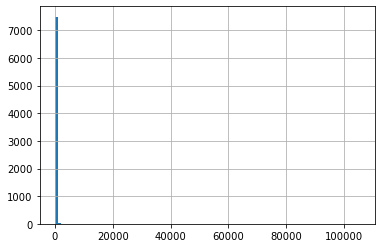

In [32]:
chr1df_o.loc[:,"unit"].hist(bins=100)

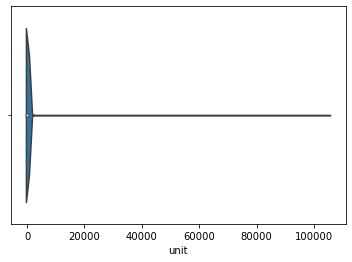

In [33]:
ax1=sns.violinplot(x=chr1df_o["unit"])

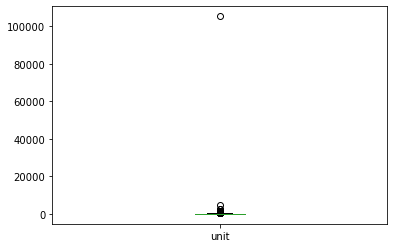

In [34]:
ax2=chr1df_o["unit"].plot.box()

In [35]:
chr1df_o_overmean=chr1df_o[chr1df_o["unit"]>chr1df_o["unit"].mean()]
len(chr1df_o_overmean)

1937

In [36]:
chr1df_o_overmean["unit"].describe()

count      1937.000000
mean        299.761487
std        2395.457201
min         112.000000
25%         141.000000
50%         184.000000
75%         269.000000
max      105248.000000
Name: unit, dtype: float64

In [37]:
##remove the 15th state from the df
df.head(100)

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,49,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO
1,chr1,9800,10600,9,800,4,I,IIII
2,chr1,10600,540400,15,529800,2649,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,2,A,AA
4,chr1,540800,569800,15,29000,145,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
...,...,...,...,...,...,...,...,...
95,chr1,951000,951400,5,400,2,E,EE
96,chr1,951400,951800,8,400,2,H,HH
97,chr1,951800,955400,5,3600,18,E,EEEEEEEEEEEEEEEEEE
98,chr1,955400,957000,1,1600,8,A,AAAAAAAA


In [38]:
df_wo_o=df[df["state"]!=15]

In [39]:
df_wo_o.head(10)

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
1,chr1,9800,10600,9,800,4,I,IIII
3,chr1,540400,540800,1,400,2,A,AA
5,chr1,569800,570000,9,200,1,I,I
7,chr1,713800,715200,1,1400,7,A,AAAAAAA
8,chr1,715200,724000,5,8800,44,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
9,chr1,724000,725000,8,1000,5,H,HHHHH
10,chr1,725000,727400,9,2400,12,I,IIIIIIIIIIII
12,chr1,761600,763200,1,1600,8,A,AAAAAAAA
14,chr1,779800,780400,7,600,3,G,GGG
15,chr1,780400,780800,5,400,2,E,EE


In [40]:
df_wo_o.tail(10)

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
510137,chrY,58998400,59001400,14,3000,15,N,NNNNNNNNNNNNNNN
510138,chrY,59001400,59001800,10,400,2,J,JJ
510139,chrY,59001800,59002000,11,200,1,K,K
510140,chrY,59002000,59002200,10,200,1,J,J
510141,chrY,59002200,59002400,13,200,1,M,M
510142,chrY,59002400,59003200,14,800,4,N,NNNN
510143,chrY,59003200,59003600,9,400,2,I,II
510144,chrY,59003600,59003800,14,200,1,N,N
510146,chrY,59005800,59006000,9,200,1,I,I
510148,chrY,59011800,59026000,9,14200,71,I,IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...


In [41]:
sample=df_wo_o.head(30)
sample  # sample is a part of df that consists of without the 15th state

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
1,chr1,9800,10600,9,800,4,I,IIII
3,chr1,540400,540800,1,400,2,A,AA
5,chr1,569800,570000,9,200,1,I,I
7,chr1,713800,715200,1,1400,7,A,AAAAAAA
8,chr1,715200,724000,5,8800,44,E,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
9,chr1,724000,725000,8,1000,5,H,HHHHH
10,chr1,725000,727400,9,2400,12,I,IIIIIIIIIIII
12,chr1,761600,763200,1,1600,8,A,AAAAAAAA
14,chr1,779800,780400,7,600,3,G,GGG
15,chr1,780400,780800,5,400,2,E,EE


In [42]:
df_wo_o.tail()["state_seq_full"]

510142                                                 NNNN
510143                                                   II
510144                                                    N
510146                                                    I
510148    IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII...
Name: state_seq_full, dtype: object

In [43]:
lst=[]
str_elm=sample["state_seq_full"].iloc[0]
str_elm

'IIII'

In [44]:
# a test function to create a list, the elm of which is the connected-pattern of the chromatin state except for quiescent state

lst=[]
str_elm=sample["state_seq_full"].iloc[0]  # the very first elm
for i in range(1, len(sample)):
    # check the index first
    cid=sample.index[i] #init=1
    pid=sample.index[i-1] # init=0
    ssf=sample["state_seq_full"]
    if (cid-pid)!=1: # if the index is separated (not a succeeding numbers)
        lst.append(str_elm)
        str_elm=ssf.iloc[i]
    else:            # if encountered a consecutive index
        str_elm+=ssf.iloc[i] # attach the next str to the previous str
        if i==len(sample)-1:   # treat the final line
            lst.append(str_elm)
lst

['IIII',
 'AA',
 'I',
 'AAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEHHHHHIIIIIIIIIIII',
 'AAAAAAAA',
 'GGGEEGGG',
 'GGGBNNNNNNNNNNNNNNNNNNNMMMMMMMMNNNNNMMMMMMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNLMMMMMMMMMMLNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMJJLMMMMMMLMMMMMMMMMMMMMMMMMMMMMMMMMMM']

In [45]:
test_df=df.head(10)

In [46]:
test_df["state_seq_full"].index[1]

1

In [47]:
def df2inbetweeen_lst(df):  # subjected to the function "df2wo15list"
    lst=[]
    df_wo_o=df[df["state"]!=15]   #remove the 15th state from the css
    css_df=df_wo_o["state_seq_full"]
    str_elm=css_df.iloc[0]  # the very first elm
    for i in range(1, len(css_df)):
        # check the index first
        cid=css_df.index[i] #init=1
        pid=css_df.index[i-1] # init=0
        ssf=css_df
        if (cid-pid)!=1: # if the index is separated (not a succeeding numbers)
            lst.append(str_elm)
            str_elm=ssf.iloc[i]
        else:            # if encountered a consecutive index
            str_elm+=ssf.iloc[i] # attach the next str to the previous str
            if i==len(css_df)-1:   # treat the final line
                lst.append(str_elm)
    return lst

In [48]:
df2inbetweeen_lst(test_df)

['IIII', 'AA', 'I', 'AAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEHHHHH']

In [49]:
def df2wo15list(df):
    total_lst=[]
    df_chr_list=df2chr_df(df)   # a list, elm of which is the df of each chromosome
    for df_chr in df_chr_list:   # for each chromosome, create a grand list by adding up the whole
        lst_chr=df2inbetweeen_lst(df_chr)
        total_lst+=lst_chr
    return total_lst

In [50]:
test_lst_cre=df2wo15list(df)

In [51]:
total_lst=df2wo15list(df)

In [52]:
len(total_lst)

97546

In [53]:
total_len_lst=[]
for lst in total_lst:
    total_len_lst.append(len(lst))

In [54]:
len(total_len_lst)

97546

In [55]:
np.mean(total_len_lst)

46.04815164127694

In [56]:
total_lst[0:4]

['IIII',
 'AA',
 'I',
 'AAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEHHHHHIIIIIIIIIIII']

In [59]:
def total_lst2kmer(total_lst,k):
    total_kmer_lst=[]
    for elm in total_lst:
        elm2kmer=seq2kmer(elm, k)
        if len(elm2kmer) >0:   # remove the short pattern... will be fine?
            total_kmer_lst.append(elm2kmer)
    return total_kmer_lst

In [60]:
total_kmer_lst=total_lst2kmer(total_lst,6)

In [61]:
total_lst[:5]

['IIII',
 'AA',
 'I',
 'AAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEHHHHHIIIIIIIIIIII',
 'AAAAAAAA']

In [62]:
len(total_kmer_lst)

65015

In [63]:
sum_len=0
for elm in total_kmer_lst:
    sum_len+=len(elm)
sum_len

28398924

In [64]:
total_3mer_lst=total_lst2kmer(total_lst,3)

In [67]:
total_4mer_lst=total_lst2kmer(total_lst,4)

In [68]:
total_5mer_lst=total_lst2kmer(total_lst,5)

In [69]:
file_name03="../database/test_data/3_tr01.txt"
with open(file_name03,"w") as g:
    g.write("\n".join(total_3mer_lst))

In [70]:
file_name04="../database/test_data/4_tr01.txt"
with open(file_name04,"w") as g:
    g.write("\n".join(total_4mer_lst))

In [71]:
file_name05="../database/test_data/5_tr01.txt"
with open(file_name05,"w") as g:
    g.write("\n".join(total_5mer_lst))

In [74]:
with open(file_name03, "r") as ff:
    lines=ff.readlines()
lines[:2]

['III III\n',
 'AAA AAA AAA AAA AAA AAE AEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEE EEH EHH HHH HHH HHH HHI HII III III III III III III III III III III\n']

In [75]:
with open(file_name04, "r") as ff:
    lines=ff.readlines()
lines[:2]

['IIII\n',
 'AAAA AAAA AAAA AAAA AAAE AAEE AEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEE EEEH EEHH EHHH HHHH HHHH HHHI HHII HIII IIII IIII IIII IIII IIII IIII IIII IIII IIII\n']

In [76]:
with open(file_name05, "r") as ff:
    lines=ff.readlines()
lines[:2]

['AAAAA AAAAA AAAAA AAAAE AAAEE AAEEE AEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEE EEEEH EEEHH EEHHH EHHHH HHHHH HHHHI HHHII HHIII HIIII IIIII IIIII IIIII IIIII IIIII IIIII IIIII IIIII\n',
 'AAAAA AAAAA AAAAA AAAAA\n']

In [94]:
file_name="../database/sample_data/pre/6_3k.txt"
with open(file_name, "r") as f:
    lines=f.readlines()

In [98]:
len(lines)

3000

In [99]:
f.close()

In [101]:
lines[:1]

['TTGGAA TGGAAA GGAAAT GAAATT AAATTG AATTGG ATTGGG TTGGGG TGGGGG GGGGGA GGGGAA GGGAAT GGAATG GAATGT AATGTG ATGTGT TGTGTT GTGTTT TGTTTT GTTTTA TTTTAC TTTACA TTACAT TACATG ACATGT CATGTG ATGTGG TGTGGA GTGGAA TGGAAG GGAAGT GAAGTA AAGTAA AGTAAT GTAATA TAATAT AATATG ATATGA TATGAA ATGAAC TGAACA GAACAT AACATG ACATGT CATGTA ATGTAA TGTAAT GTAATA TAATAG AATAGT ATAGTA TAGTAC AGTACA GTACAT TACATG ACATGT CATGTA ATGTAA TGTAAG GTAAGT TAAGTT AAGTTA AGTTAC GTTACT TTACTG TACTGT ACTGTA CTGTAC TGTACT GTACTA TACTAA ACTAAC CTAACA TAACAA AACAAA ACAAAG CAAAGT AAAGTA AAGTAC AGTACA GTACAG TACAGA ACAGAC CAGACT AGACTT GACTTC ACTTCG CTTCGT TTCGTT TCGTTA CGTTAG GTTAGG TTAGGC TAGGCA AGGCAG GGCAGC GCAGCT CAGCTT AGCTTA GCTTAG CTTAGG TTAGGG TAGGGG AGGGGA GGGGAT GGGATG GGATGG GATGGC ATGGCT TGGCTC GGCTCC GCTCCC CTCCCA TCCCAA CCCAAT CCAATA CAATAC AATACT ATACTC TACTCT ACTCTT CTCTTT TCTTTC CTTTCT TTTCTT TTCTTC TCTTCC CTTCCT TTCCTG TCCTGG CCTGGT CTGGTG TGGTGT GGTGTT GTGTTG TGTTGA GTTGAT TTGATG TGATGG GATGGA ATGGAT TGGATT GGAT

In [105]:
file_name02="../database/test_data/6_tr01.txt"
with open(file_name02,"w") as g:
    g.write("\n".join(total_kmer_lst))


In [106]:
g.close()

In [107]:
with open(file_name02, "r") as ff:
    lines=ff.readlines()

In [108]:
lines[:1]

['AAAAAA AAAAAA AAAAAE AAAAEE AAAEEE AAEEEE AEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEE EEEEEH EEEEHH EEEHHH EEHHHH EHHHHH HHHHHI HHHHII HHHIII HHIIII HIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII IIIIII\n']

In [109]:
ff.close()

In [85]:
test_kmer=seq2kmer("ABCDEFGHIJKLMNO", 6)
test_kmer

'ABCDEF BCDEFG CDEFGH DEFGHI EFGHIJ FGHIJK GHIJKL HIJKLM IJKLMN JKLMNO'

In [87]:
type(test_kmer)

str

In [52]:
len(test_lst_cre)

97546

In [53]:
test_elm_len=[]
for elm in test_lst_cre:
    test_elm_len.append(len(elm))
test_elm_len

[4,
 2,
 1,
 68,
 8,
 8,
 1112,
 10,
 41,
 387,
 534,
 113,
 115,
 10,
 177,
 9,
 57,
 27,
 145,
 3,
 86,
 354,
 93,
 178,
 5,
 2,
 956,
 119,
 92,
 4,
 119,
 65,
 94,
 185,
 6,
 6,
 62,
 1,
 8,
 220,
 30,
 77,
 196,
 238,
 26,
 326,
 17,
 2,
 329,
 194,
 14,
 55,
 337,
 132,
 10,
 29,
 71,
 4,
 13,
 53,
 54,
 5,
 22,
 26,
 12,
 85,
 36,
 281,
 97,
 19,
 8,
 9,
 38,
 297,
 88,
 568,
 12,
 3,
 122,
 1,
 13,
 1079,
 7,
 204,
 62,
 137,
 13,
 11,
 44,
 4,
 24,
 6,
 4,
 14,
 3,
 4,
 10,
 2,
 9,
 16,
 2,
 17,
 14,
 9,
 1,
 1,
 20,
 3,
 10,
 6,
 12,
 15,
 1,
 4,
 21,
 78,
 17,
 5,
 57,
 4,
 4,
 11,
 4,
 4,
 25,
 7,
 3,
 7,
 9,
 4,
 13,
 1,
 1,
 11,
 4,
 5,
 5,
 4,
 4,
 6,
 11,
 9,
 2,
 4,
 13,
 15,
 11,
 35,
 9,
 5,
 2,
 2,
 21,
 51,
 15,
 3,
 11,
 2,
 4,
 4,
 5,
 2,
 46,
 12,
 30,
 1,
 4,
 4,
 1,
 302,
 3,
 4,
 6,
 52,
 8,
 4,
 6,
 4,
 30,
 5,
 2,
 37,
 45,
 43,
 63,
 2,
 4,
 5,
 254,
 4,
 68,
 4,
 33,
 47,
 351,
 208,
 37,
 513,
 528,
 190,
 221,
 464,
 1,
 23,
 27,
 10,
 183,
 41,
 8,
 14

In [54]:
def css_elm_stat(total_lst):
    len_lst=[]
    for elm in total_lst:
        assert type(elm)==str, "element type is not string"
        len_lst.append(len(elm))
    print("total count: ", len(total_lst))
    print("max length: ", max(len_lst))
    print("min length: ", min(len_lst))
    print("average length: ",np.mean(len_lst))
    fig =plt.figure(figsize=(6,4))
    plt.hist(len_lst, bins=20, log=True, color="teal", edgecolor="white")
    plt.xlabel("length of chromatin state pattern", fontsize=14)
    plt.ylabel("Count", fontsize=14)

total count:  97546
max length:  2981
min length:  1
average length:  46.04815164127694


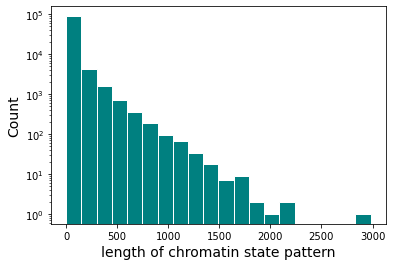

In [55]:
css_elm_stat(test_lst_cre)

In [56]:
def lst2let_compose(total_lst):
    letter_cnt=[]
    for word in total_lst:
        chk_let=word[0]
        num_let=1
        for let in word:
            if let!=chk_let:
                num_let+=1
                chk_let=let
        letter_cnt.append(num_let)
    print("total count: ", len(letter_cnt))
    print("max composition: ", max(letter_cnt))
    print("min composition: ", min(letter_cnt))
    print("average composition: ", np.mean(letter_cnt))
    fig =plt.figure(figsize=(6,4))
    plt.hist(letter_cnt, bins=20, log=True, color="orange", edgecolor="white")
    plt.xlabel("number of state in a composition", fontsize=14)
    plt.ylabel("Count", fontsize=14)

total count:  97546
max composition:  249
min composition:  1
average composition:  4.229307198654993


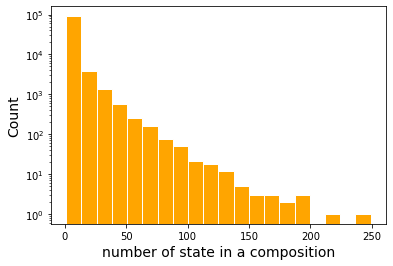

In [57]:
lst2let_compose(test_lst_cre)

In [58]:
def custom_colorlist(data_dict):
    
    """ 
    INPUT: solo chromatin state data in dict such as 
           data_dict={'I': 114, 'A': 23, 'N': 119, 'G': 33, 'E': 131, 'H': 1}
    OUTPUT: customized colormap according to ROADMAP (type=list)
    """
    state_list=list(data_dict.keys())
    colormap_list=[]
    assert type(state_list[0])==str
    for state in state_list:
        if css_dict[state] in css_name_col_dict.keys():
            color_rgb=css_name_col_dict[css_dict[state]]
            colormap_list.append(color_rgb)
    return colormap_list

In [59]:
# dict of lst and number (refer what is the main letter if there is only one composition )

def lst2cntdict(total_lst):
    letter_cnt=[]
    for word in total_lst:
        chk_let=word[0]
        num_let=1
        for let in word:
            if let!=chk_let:
                num_let+=1
                chk_let=let
        letter_cnt.append(num_let)
    css_lst_dict=dict(zip(total_lst, letter_cnt))
    return css_lst_dict

In [60]:
total_lst=test_lst_cre
lst2cntdict(total_lst)

{'IIII': 1,
 'AA': 1,
 'I': 1,
 'AAAAAAAEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEHHHHHIIIIIIIIIIII': 4,
 'AAAAAAAA': 1,
 'GGGEEGGG': 3,
 'GGGBNNNNNNNNNNNNNNNNNNNMMMMMMMMNNNNNMMMMMMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNLMMMMMMMMMMLNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNNNNNNNNNNMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMJJLMMMMMMLMMMMMMMMMMMMMMMMMMMMMMMMMMMLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMLLLLLKMMMMMMMMLLJMMMMJJJMMMKMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMKKLLLLMMMMMMMMMMMMMMLLLLLKJJJJJJJMMMMMMMMMMMMMMNNEEEEEEEEEEEEEEEEEEEEEEEEEDDDDDDDEEEEEEEEEEEEEEEEEEEEDDDDDDDDEEEEGGGEAAJJMMMMMJJJJJJJJMMMNNNNNNNNNNNNNMMMMMMJJJJJMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMJJJMNNNNNNNNMMMNNNNNNNNNNNMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNMMMMMMMNNNNNNNNNNNNNMMMMMMMMMMMMMMMMMMMMMMLLLMMMMJJJJJJJJJJJJJJJJJMMMMMMMMMMMLLLLLLLLMMMMLMMMMNNNNNNNNNNNNNNNNNNNNNNNNNNNAAAAAAABBGGGGGEEHHEEEEEEEEEEEEEEEEEEAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGGGGEEEEEEEEEEEEEEEE

In [61]:
def lst2solo_compose(total_lst):# graph of a solo pattern frequency
    
    """INPUT: the entire list of in-between pattern w.o. 15th state (total_lst)
       OUTPUT: the most/least frequent solo pattern and the frequency graph
    """
    
    letter_cnt=[]
    for word in total_lst:
        chk_let=word[0]
        num_let=1
        for let in word:
            if let!=chk_let:
                num_let+=1
                chk_let=let
        letter_cnt.append(num_let)
    css_lst_dict=dict(zip(total_lst, letter_cnt))
    
    lst_for_solo=[]               # prepare to make a solo pattern list
    solo_dist={}                  # prepare to make a solo pattern length distribution dict
    for pattern, num in list(css_lst_dict.items()): # as a tuple element (key, val)
        if num==1:
            lst_for_solo.append(pattern[0])
            key=str(pattern[0])
            if key not in solo_dist.keys():
                solo_dist[key]=[len(pattern)]
            else:
                solo_dist[key].append(len(pattern))
                
    solo_counter=collections.Counter(lst_for_solo)
    solo_data_dict=dict(solo_counter) # ditionary of solo pattern and the frequency
    solo_data_dict=dict(sorted(solo_data_dict.items(), reverse=True, key=lambda item: item[1]))
    my_color=custom_colorlist(solo_data_dict)  # create a customized colormap using solo data
    
    for pattern, num in solo_data_dict.items():
        if num is max(solo_data_dict.values()):
            max_state=pattern
            max_num=num
        elif num is min(solo_data_dict.values()):
            min_state=pattern
            min_num=num

    print("frequency of solo pattern: ", len(lst_for_solo))
    print("the most frequent solo pattern: ", css_dict[max_state], " for ", max_num, " times appeared." )
    print("the least frequent solo pattern: ", css_dict[min_state], " for ", min_num, " times appeared." )
    
    x=[css_dict[state] for state in solo_data_dict.keys()]
    y=solo_data_dict.values()
    
    fig1 =plt.figure(figsize=(6,4))
    plt.bar(x,y, color=my_color)
    plt.xlabel("solo pattern", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    
#     fig2, ax=plt.subplots(figsize=(6,4))
#     solo_data=list(solo_dist.values())
    

frequency of solo pattern:  421
the most frequent solo pattern:  TxWk  for  131  times appeared.
the least frequent solo pattern:  ZNF/Rpts  for  1  times appeared.


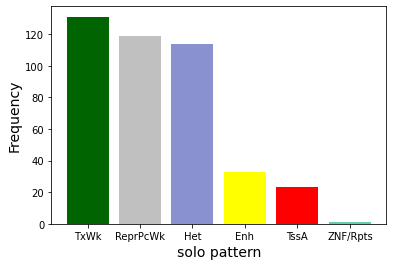

In [62]:
lst2solo_compose(total_lst)

### prepare the 6-mer data of 200-bp annotated CSS

NameError: name 'solo_dist' is not defined

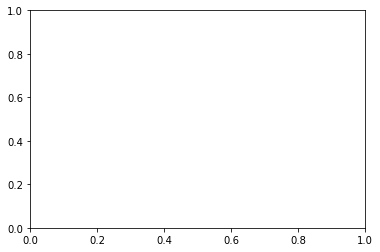

In [67]:
fig2, ax=plt.subplots(figsize=(6,4))
solo_data=list(solo_dist.values())
ax.violinplot(solo_data,showmeans=False, showmedians=True)

In [68]:
solo_data_dict

NameError: name 'solo_data_dict' is not defined

In [147]:
my_pal=custom_colorlist(solo_dist)

In [153]:
solo_data

[[8,
  2,
  20,
  18,
  16,
  28,
  10,
  52,
  24,
  14,
  26,
  22,
  12,
  32,
  4,
  40,
  34,
  50,
  6,
  30,
  42,
  62,
  58,
  36,
  60,
  46,
  72,
  56,
  64,
  44,
  90,
  86,
  78,
  54,
  38,
  84,
  70,
  98,
  66,
  48,
  68,
  76,
  108,
  96,
  88,
  116,
  102,
  80,
  74,
  104,
  164,
  94,
  110,
  82,
  136,
  122,
  132,
  100,
  106,
  176,
  118,
  142,
  194,
  114,
  124,
  112,
  144,
  304,
  126,
  92,
  134,
  120,
  138,
  140,
  128,
  382,
  1004,
  130,
  218,
  186,
  148,
  234,
  530,
  160,
  328,
  184,
  158,
  220,
  272,
  208,
  196,
  276,
  152,
  238,
  178,
  170,
  192,
  156,
  286,
  390,
  244,
  462,
  202,
  206,
  172,
  166,
  150,
  162,
  312,
  242,
  182,
  146,
  268,
  180],
 [4,
  16,
  6,
  10,
  14,
  18,
  28,
  26,
  8,
  12,
  20,
  24,
  32,
  42,
  30,
  2,
  22,
  36,
  66,
  34,
  38,
  44,
  40],
 [4,
  58,
  142,
  26,
  108,
  44,
  72,
  194,
  30,
  2,
  136,
  54,
  36,
  18,
  34,
  10,
  8,
  46,
  96,
  2

In [59]:
css_name_col_dict

{'TssA': (0.8588235294117647, 0.2235294117647059, 0.19607843137254902),
 'TssAFlnk': (0.8705882352941177, 0.3411764705882353, 0.21176470588235294),
 'TxFlnk': (0.4196078431372549, 0.7333333333333333, 0.3411764705882353),
 'Tx': (0.2235294117647059, 0.48627450980392156, 0.2823529411764706),
 'TxWk': (0.18823529411764706, 0.3843137254901961, 0.22745098039215686),
 'EnhG': (0.7725490196078432, 0.8352941176470589, 0.3137254901960784),
 'Enh': (0.9607843137254902, 0.7686274509803922, 0.3843137254901961),
 'ZNF/Rpts': (0.5058823529411764, 0.7607843137254902, 0.6627450980392157),
 'Het': (0.5372549019607843, 0.5607843137254902, 0.7411764705882353),
 'TssBiv': (0.7529411764705882, 0.3843137254901961, 0.37254901960784315),
 'BivFlnk': (0.8745098039215686, 0.611764705882353, 0.4980392156862745),
 'EnhBiv': (0.7372549019607844, 0.7137254901960784, 0.45098039215686275),
 'ReprPC': (0.5764705882352941, 0.5843137254901961, 0.6),
 'ReprPcWk': (0.7843137254901961, 0.792156862745098, 0.796078431372549)

In [60]:
total_lst=df2wo15list(df)

In [61]:
css_lst_dict=lst2cntdict(total_lst)

In [62]:
import collections

In [93]:
lst_for_solo=[]
for pattern, num in list(css_lst_dict.items()):
    if num==1:
        lst_for_solo.append(pattern[0])
lst_for_solo

['I',
 'A',
 'I',
 'A',
 'I',
 'I',
 'A',
 'A',
 'N',
 'I',
 'G',
 'I',
 'N',
 'N',
 'N',
 'N',
 'I',
 'N',
 'I',
 'I',
 'N',
 'N',
 'G',
 'I',
 'I',
 'I',
 'G',
 'I',
 'G',
 'G',
 'I',
 'I',
 'I',
 'N',
 'N',
 'I',
 'G',
 'G',
 'I',
 'I',
 'G',
 'G',
 'I',
 'I',
 'E',
 'N',
 'G',
 'I',
 'N',
 'A',
 'G',
 'N',
 'N',
 'N',
 'G',
 'N',
 'N',
 'I',
 'N',
 'N',
 'I',
 'I',
 'G',
 'I',
 'E',
 'I',
 'N',
 'I',
 'N',
 'N',
 'N',
 'I',
 'I',
 'I',
 'N',
 'E',
 'E',
 'N',
 'N',
 'G',
 'G',
 'E',
 'A',
 'E',
 'N',
 'G',
 'I',
 'N',
 'I',
 'I',
 'I',
 'E',
 'N',
 'E',
 'E',
 'E',
 'I',
 'E',
 'A',
 'N',
 'A',
 'N',
 'I',
 'I',
 'E',
 'I',
 'E',
 'N',
 'E',
 'E',
 'E',
 'I',
 'I',
 'A',
 'I',
 'E',
 'A',
 'G',
 'E',
 'A',
 'E',
 'E',
 'N',
 'G',
 'A',
 'I',
 'A',
 'N',
 'E',
 'A',
 'E',
 'N',
 'E',
 'A',
 'N',
 'N',
 'N',
 'N',
 'E',
 'I',
 'E',
 'G',
 'E',
 'A',
 'N',
 'A',
 'N',
 'N',
 'N',
 'E',
 'N',
 'I',
 'I',
 'E',
 'G',
 'N',
 'G',
 'G',
 'I',
 'A',
 'I',
 'E',
 'I',
 'E',
 'E',
 'G',
 'G'

In [120]:
solo_dist={}
type(solo_dist)

dict

In [135]:
solo_dist={}
for pattern, num in list(css_lst_dict.items()):
    if num==1:
        key=str(pattern[0])
        if key not in solo_dist.keys():
            solo_dist[key]=[len(pattern)]
        else:
            solo_dist[key].append(len(pattern))

In [ ]:
for key, value in solo_dist.items():
    solo_df=pd.DataFrame

In [143]:
solo_df=pd.DataFrame({key:pd.Series(value) for key, value in solo_dist.items()})


<AxesSubplot:>

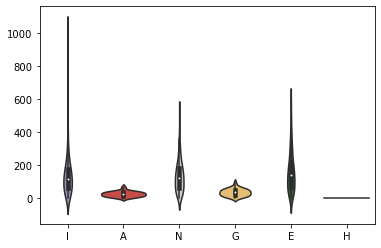

In [148]:
sns.violinplot(data=solo_df, palette=my_pal)

In [138]:
import seaborn as sns

In [7]:
def all_chr2txt(all_chr_css, cell_num):
    """Generate a txt file from the all connected css."""
    cell_num=str(cell_num)
    file_name="../database/css_txt/css_all_"+cell_num+".txt"
    with open(file_name, "w") as f:
        f.write(all_chr_css)
    f.close()

In [31]:
def pickle2all_css(pickle, file_name, path2save):
    """Convert pickle dataframe into all-chromosome connected css and save it as .txt"""
    df=pd.read_pickle(pickle)
    all_chr_css=df2css_allchr(df)
    cell_num=re.findall(r'\d+',file_name)[0] #[0] added to extract the elm only   
    
    def all_chr2txt(all_chr_css, cell_num, path2save):
        """Generate a txt file from the all connected css.
        under the folder ../database/css_txt/ """
        assert (type(path2save)==str), "path should be string type"
        assert type(cell_num)==str, "cell number should be string type"
        file_name=path2save+"css_all_"+cell_num+".txt"
        with open(file_name, "w") as f:
            f.write(all_chr_css)
        f.close()
    
    all_chr2txt(all_chr_css, cell_num, path2save)
    return ("all files are saved in "+path2save)
    

In [23]:
cell_num_list=[]
for file_name in all_cell_pickles:
    cell_num=re.findall(r'\d+',file_name)
    cell_num_list.append(cell_num[0]) #[0] added to extract the elm only
print(cell_num_list)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127']


In [30]:
re.findall(r'\d+',file_name)[0]

'127'

In [27]:
assert type(cell_num_list[0][0])!=str 

In [9]:
all_cell_pickles[0]

'../database/cell_pickle/df_cell001.pkl'

In [10]:
all_cell_pickles[0]

'../database/cell_pickle/df_cell001.pkl'

In [11]:
import re

In [12]:
re.findall(r'\d+', all_cell_pickles[0])

['001']

#### Transform into Dataframe from bed file

In [15]:
test_file_bed=all_files[0]
test_file_bed

'../database/bed/unzipped/E001_15_coreMarks_stateno.bed'

In [16]:
df_test1=bed2df_as_is(test_file_bed)
df_test1.head()

,chromosome,start,end,state
0,chr1,0,9800,15
1,chr1,9800,10600,9
2,chr1,10600,540400,15
3,chr1,540400,540800,1
4,chr1,540800,569800,15


In [17]:
df_test1ex=bed2df_expanded(test_file_bed)
df_test1ex.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


#### Read pickled file (unpickling)

In [18]:
df=pd.read_pickle("../database/cell_pickle/df_cell001.pkl")
df.head()

,chromosome,start,end,state,length,unit,state_seq,state_seq_full
0,chr1,0,9800,15,9800,98,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
1,chr1,9800,10600,9,800,8,I,IIIIIIII
2,chr1,10600,540400,15,529800,5298,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
3,chr1,540400,540800,1,400,4,A,AAAA
4,chr1,540800,569800,15,29000,290,O,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [19]:
state_seq_full_to_str=df2css_allchr(df)

#### State initial and normalized RGB
*colors2color_dec*

In [20]:
state_col_dict

{'A': (0.8588235294117647, 0.2235294117647059, 0.19607843137254902),
 'B': (0.8705882352941177, 0.3411764705882353, 0.21176470588235294),
 'C': (0.4196078431372549, 0.7333333333333333, 0.3411764705882353),
 'D': (0.2235294117647059, 0.48627450980392156, 0.2823529411764706),
 'E': (0.18823529411764706, 0.3843137254901961, 0.22745098039215686),
 'F': (0.7725490196078432, 0.8352941176470589, 0.3137254901960784),
 'G': (0.9607843137254902, 0.7686274509803922, 0.3843137254901961),
 'H': (0.5058823529411764, 0.7607843137254902, 0.6627450980392157),
 'I': (0.5372549019607843, 0.5607843137254902, 0.7411764705882353),
 'J': (0.7529411764705882, 0.3843137254901961, 0.37254901960784315),
 'K': (0.8745098039215686, 0.611764705882353, 0.4980392156862745),
 'L': (0.7372549019607844, 0.7137254901960784, 0.45098039215686275),
 'M': (0.5764705882352941, 0.5843137254901961, 0.6),
 'N': (0.7843137254901961, 0.792156862745098, 0.796078431372549),
 'O': (0.9411764705882353, 0.9411764705882353, 0.9411764705

#### Number of chromosome
*numchr*

In [21]:
num_chromosome=numchr(df)
num_chromosome

25

#### Create a large piece of string of the whole state_seq_full in a cell
*df2css_allchar*

In [22]:
all_chr_css=df2css_allchr(df)
all_chr_css[10000:10200]

'MMMMMMMMMMMMKKMMMMMMMMMMMMMMMMMMMMMMMMJJJJJJJJJJJJMMMMMMMMLLLLMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMNNNNNNNNNNNNNNNNNNNNJJJJJJAAAAAAOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

In [23]:
colored_css_str(all_chr_css[11200:13900])

N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N O O O O O O O O O O O O O O O O O O O O I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I I N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N M M M M M M L L M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M M N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N N G G E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E D D E E E E E E E E E E E E D D D D D D D D E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E A A A A A A A A A A A A N N N N N N N N M M M M M M M M N N N N N N N N N N 

In [32]:
def all_chr2txt(all_chr_css, cell_num):
    """Generate a txt file from the all connected css."""
    cell_num=str(cell_num)
    file_name="css_all_"+cell_num+".txt"
    with open(file_name, "w") as f:
        f.write(all_chr_css)
    f.close()

In [ ]:
## total pickle file list maker
def pickle_list_maker(pickle_path):
    

In [33]:
pickle_path='../database/cell_pickle'

In [38]:
pickle_files=os.listdir(pickle_path)

In [65]:
pickle_path

'../database/cell_pickle'

In [30]:
## save it as a file
with open("test_css2txt.txt","w") as ws:
    ws.write(all_chr_css)

In [31]:
ws.close()

#### Create CSS chromosome-wise
* *df2char_index* : the index (row no.) where each chromosome ends <br>
* *df2css_chr* : create a list of **dataframes**, each of which contains chromosome names and state_seq_full <br>
* *df2css_chr_str* : create a list of **strings** of state_seq_full, all connected per chromosome

In [15]:
chr_index=df2chr_index(df)
chr_index

[45243,
 84706,
 118779,
 146272,
 175237,
 204827,
 231085,
 254353,
 275223,
 298155,
 323185,
 348498,
 362434,
 378184,
 393196,
 408978,
 431073,
 442950,
 459355,
 471900,
 477268,
 486157,
 486165,
 509936,
 510149]

In [221]:
df_chr_list=df2css_chr(df)

In [222]:
df_chr_list[2].head()

,chromosome,state_seq_full
84707,chr3,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...
84708,chr3,GGGG
84709,chr3,EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE...
84710,chr3,GGGGGGGGGGGGGG
84711,chr3,OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO...


In [223]:
chr_css_list=df2css_chr_str(df)

In [224]:
chr_css_list[2][1000:1200]

'OOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOGGGGEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEGGGGGGGGGGGGGGOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO'

#### CSS Pattern analysis
*css_list2count* 
* input: df, chr_css_list
* output; count_all (a dataframe where row=states, column=chromosomes)

In [225]:
count_all=css_list2count(df, chr_css_list)

In [226]:
count_all

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY
A,29630,21000,18162,13428,15666,20234,15376,11350,11672,12044,...,11660,14596,5258,20840,7282,3020,5706,0,13860,44
B,8286,5596,5070,3576,4214,4918,3694,3162,3076,3298,...,2540,4842,1544,2798,2178,730,1596,0,3744,0
C,1092,410,578,426,588,712,392,328,332,240,...,164,486,128,354,302,64,94,0,476,4
D,48450,28844,24862,13432,21428,17066,18322,14210,17464,18234,...,20024,34246,5556,19834,14288,5330,11592,0,10668,6
E,401910,350518,312084,223202,241968,248700,237870,179962,186804,187476,...,148230,186618,97808,142212,111134,43898,90434,0,171668,290
F,2872,1598,1892,1194,1782,1476,1450,1416,1178,1522,...,730,2074,456,912,1044,314,600,0,1016,0
G,105692,93098,86782,63048,70438,72130,58276,54310,48378,52250,...,32706,44466,30376,17742,26694,11236,19116,0,52596,0
H,4558,4890,3684,4278,3860,3720,4912,3222,3022,4744,...,3432,2190,1232,10128,1328,1678,790,2,4726,2188
I,54650,65612,54810,59348,55184,46736,46958,44752,27308,36088,...,17968,20010,19642,35424,11958,11804,6264,58,61612,1462
J,11378,9264,6042,5692,6302,7318,5884,5558,5294,6544,...,4090,7662,2744,6398,3448,1266,2264,0,3786,26


In [227]:
count_all_renamed=count_all.rename(index=css_dict)

In [228]:
count_all_renamed

,chr1,chr2,chr3,chr4,chr5,chr6,chr7,chr8,chr9,chr10,...,chr16,chr17,chr18,chr19,chr20,chr21,chr22,chrM,chrX,chrY
TssA,29630,21000,18162,13428,15666,20234,15376,11350,11672,12044,...,11660,14596,5258,20840,7282,3020,5706,0,13860,44
TssAFlnk,8286,5596,5070,3576,4214,4918,3694,3162,3076,3298,...,2540,4842,1544,2798,2178,730,1596,0,3744,0
TxFlnk,1092,410,578,426,588,712,392,328,332,240,...,164,486,128,354,302,64,94,0,476,4
Tx,48450,28844,24862,13432,21428,17066,18322,14210,17464,18234,...,20024,34246,5556,19834,14288,5330,11592,0,10668,6
TxWk,401910,350518,312084,223202,241968,248700,237870,179962,186804,187476,...,148230,186618,97808,142212,111134,43898,90434,0,171668,290
EnhG,2872,1598,1892,1194,1782,1476,1450,1416,1178,1522,...,730,2074,456,912,1044,314,600,0,1016,0
Enh,105692,93098,86782,63048,70438,72130,58276,54310,48378,52250,...,32706,44466,30376,17742,26694,11236,19116,0,52596,0
ZNF/Rpts,4558,4890,3684,4278,3860,3720,4912,3222,3022,4744,...,3432,2190,1232,10128,1328,1678,790,2,4726,2188
Het,54650,65612,54810,59348,55184,46736,46958,44752,27308,36088,...,17968,20010,19642,35424,11958,11804,6264,58,61612,1462
TssBiv,11378,9264,6042,5692,6302,7318,5884,5558,5294,6544,...,4090,7662,2744,6398,3448,1266,2264,0,3786,26


In [254]:
# create a def to draw the content of chromatin state per chromosome using count_all
def draw_count_barplot_incl15(count_all, chr_no):
    
    """ Draw a bar plot (chromatin state vs. count) per chromosome
    input(1) table of 'count_all' which is created by the function css_list2count(df, chr_css_list) 
    input(2) chromosome name in string, e.g.) 'chr1', 'chr2', ... 
    output: bar plot of the all chromatin state count (including 15th state)"""

    count_all_renamed=count_all.rename(index=css_dict)
    color_dec=colors2color_dec(css_color_dict)
    ax0=count_all_renamed.loc[:,chr_no].plot.bar(rot=45, color=color_dec)
    ax0.set_ylabel("Counts", fontsize=14)
    

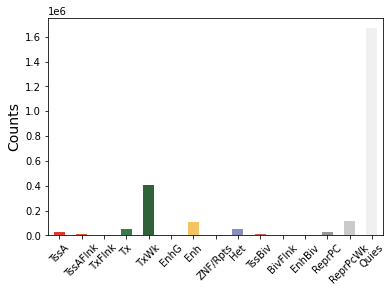

In [255]:
draw_count_barplot_incl15(count_all, "chr1")

In [256]:
def draw_count_barplot_wo15(count_all, chr_no):
    
    """ Draw a bar plot (chromatin state vs. count) per chromosome
    input(1) table of 'count_all' which is created by the function css_list2count(df, chr_css_list) 
    input(2) chromosome name in string, e.g.) 'chr1', 'chr2', ... 
    output: bar plot of the all chromatin state count except for 15th state"""

    count_all_renamed=count_all.rename(index=css_dict)
    color_dec=colors2color_dec(css_color_dict)
    ax0=count_all_renamed.loc[:,chr_no][:-1].plot.bar(rot=45, color=color_dec)
    ax0.set_ylabel("Counts", fontsize=14)

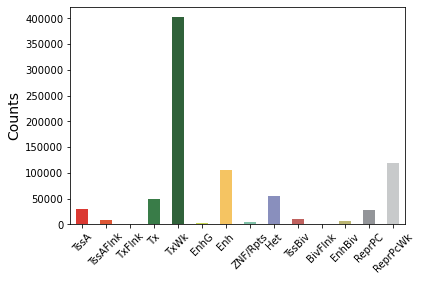

In [257]:
draw_count_barplot_wo15(count_all, "chr1")

In [28]:
count_all.sum().sum()  # total number of css contained in 1 cell sample

30956914

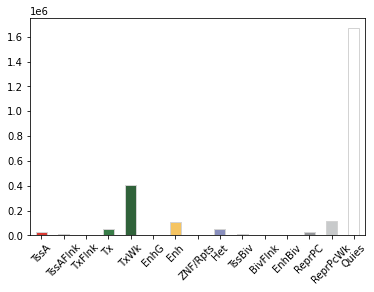

In [55]:
color_dec=colors2color_dec(css_color_dict)
ax0=count_all_renamed.loc[:,"chr1"].plot.bar(rot=45, color=color_dec, edgecolor="lightgray")  # total state

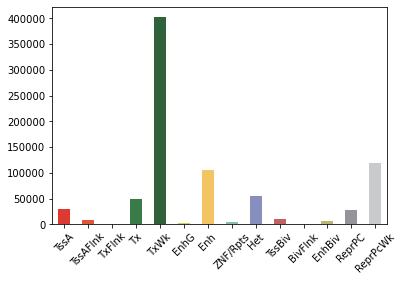

In [56]:
ax1=count_all_renamed.loc[:,"chr1"][:-1].plot.bar(rot=45, color=color_dec)  # except for Quies

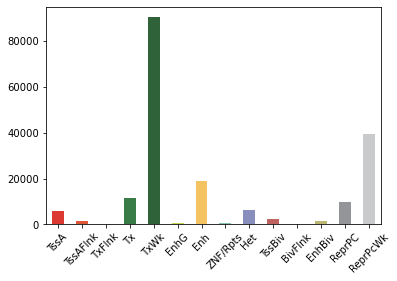

In [68]:
ax1=count_all_renamed.loc[:,"chr22"][:-1].plot.bar(rot=45, color=color_dec)  # except for Quies

In [43]:
# df_test=json.load("./cell_json/df_cell001.json")
# df_test